# classes and functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import sys
import os
import glob
import configparser

import h5py
import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

matplotlib.rcParams.update({'font.size': 20})

In [2]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [3]:
class SingleModeNRWaveform(object):
    def __init__(self, nrfile, ell, mm, npts, t1=None, t2=None):

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_lm_mode(self.nrfile, ell, mm, self.npts)


    def get_lm_mode(self, nrfile, ell, mm, npts):
        
        if 'SXS' in nrfile:
            f = h5py.File(nrfile, 'r')

            self.q = f.attrs['mass1']/f.attrs['mass2']
            self.eta = f.attrs['eta']

            amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
            amp_x = amp_tmp['X'].value
            amp_y = amp_tmp['Y'].value

            phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
            phase_x = phase_tmp['X'].value
            phase_y = phase_tmp['Y'].value

            f.close()
        else:
            # bam
            self.sim_dir = os.path.dirname(nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
            # strict=False because of DuplicateSectionError
            config = configparser.ConfigParser(strict=False)

            config.read(self.bbh_file)
            mass1_tmp = float(config['metadata']['mass1'])
            mass2_tmp = float(config['metadata']['mass2'])
            self.initial_sep = float(config['metadata']['initial-separation'])

            if mass1_tmp >= mass2_tmp:
                mass1 = mass1_tmp
                mass2 = mass2_tmp
            else:
                mass1 = mass2_tmp
                mass2 = mass1_tmp


            self.mass1 = mass1
            self.mass2 = mass2
            self.mtot = self.mass1 + self.mass2
            self.q = self.mass1 / self.mass2
            self.eta = self.mass1 * self.mass2 / (self.mtot)**2.
            
            times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

            # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
            hlm = re_hlm - 1.j * im_hlm
            
            amp_x = times
            amp_y = np.abs(hlm)

            phase_x = times
            phase_y = np.unwrap(np.angle(hlm))
            
            
        # shift so that amp peak is at t=0 - will need to be more careful with HMs
        amp_peak_idx = amp_y.argmax()
        amp_peak_time = amp_x[amp_peak_idx]
        amp_x = amp_x - amp_peak_time
        phase_x = phase_x - amp_peak_time
            

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        if self.t1 is None:
            self.t1 = max(amp_x[0], phase_x[0])
        if self.t2 is None:
            self.t2 = min(amp_x[-1], phase_x[-1])
            
        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [4]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.2f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        # index of maximum
        max_idx_hlm = self.hlm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_hlm = self.nrdata.times[max_idx_hlm]
        
        self.times_hlm = self.nrdata.times - self.time_at_max_idx_hlm
        

        # news
        newslmre = ihlmre.derivative()(self.times_hlm)
        newslmim = ihlmim.derivative()(self.times_hlm)

        self.newslm = newslmre - 1.j*newslmim
        
        self.newslm_amp = np.abs(self.newslm)
        
        # index of maximum
        max_idx_news = self.newslm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_news = self.nrdata.times[max_idx_news]
        
        self.times_news = self.nrdata.times - self.time_at_max_idx_news
        
        self.newslm_phase = np.unwrap(np.angle(self.newslm))
        i_newslm_phase = IUS(self.times_news, self.newslm_phase)
        self.newslm_ang_freq = i_newslm_phase.derivative()(self.times_news)
        
        
        
        # psi4
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

In [5]:
# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
    q18="/Users/spx8sk/work/data/q18a0a0c025_144/h3col.r7.l5.l2.m2"
)

In [6]:
ell = 2
mm = 2

npts_time = 1000*2
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
t1=-600
# t1=-1000
# t1=-800
t2=60


In [7]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [8]:
for k in psi4s.keys():
    print("{} = {}".format(k, 1./psi4s[k].fdamp/2/np.pi))

q1 = 11.706422641558191
q2 = 11.554740530290251
q4 = 11.36516841490208
q5 = 11.32930696199893
q10 = 11.272552160962043
q18 = 11.255711435422901


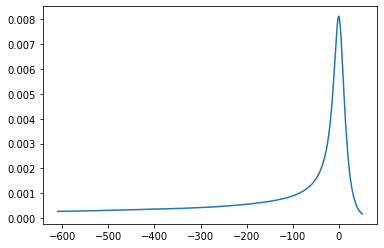

In [9]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_amp)

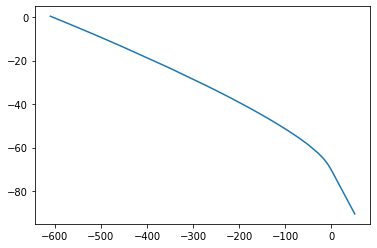

In [10]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_phase)

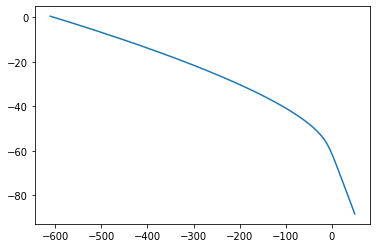

In [11]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

Text(0.5, 1.0, '$|h|(t)$')

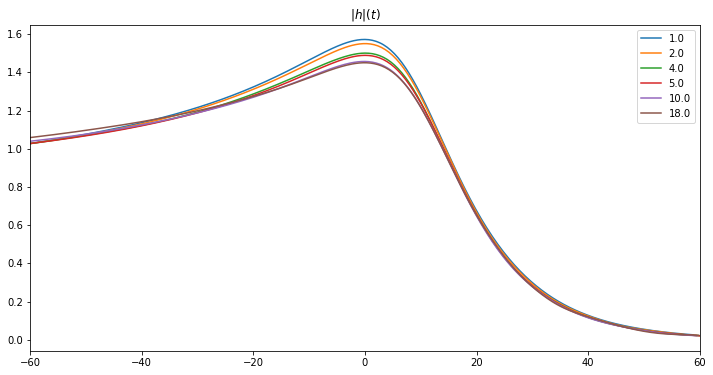

In [12]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
#     plt.plot(psi4s[k].times, psi4s[k].hlm_amp, label=psi4s[k].q)
plt.legend()
plt.xlim(-60,60)
# plt.ylim(0.2, 1.6)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|N|(t)$')

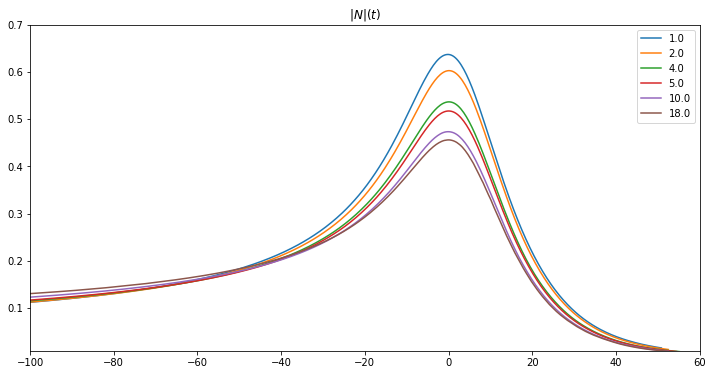

In [13]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.7)
# plt.yscale('log')
plt.title(r'$|N|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

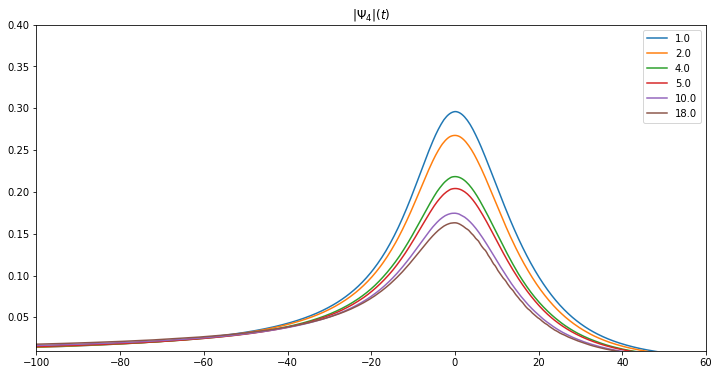

In [14]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.4)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $h$')

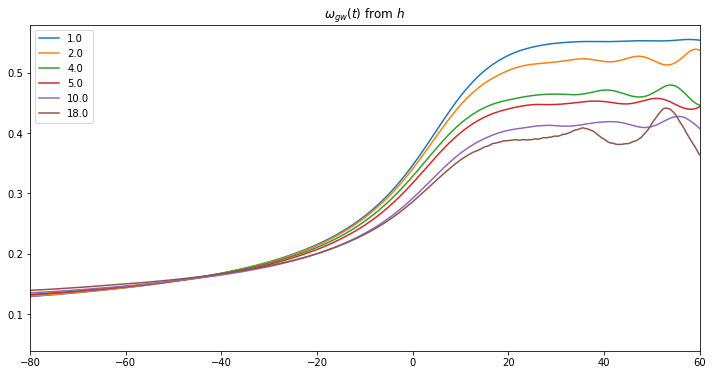

In [15]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $h$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from News')

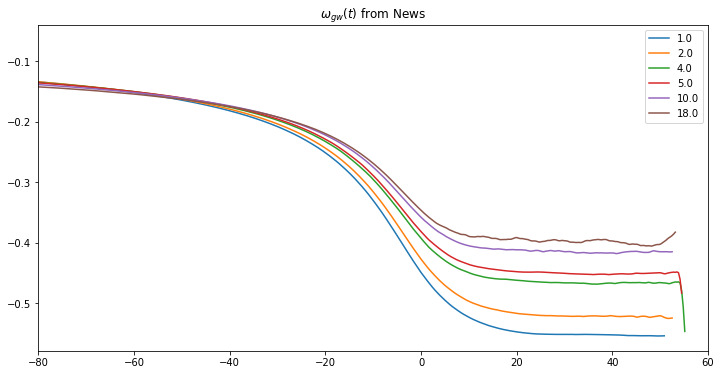

In [16]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from News')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

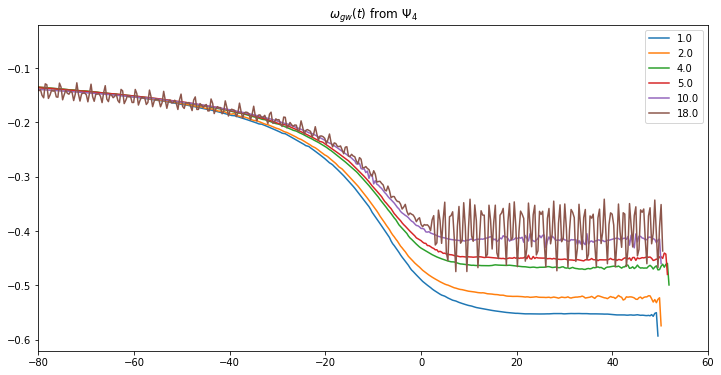

In [17]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

Text(0.5, 1.0, 'q = 1.0')

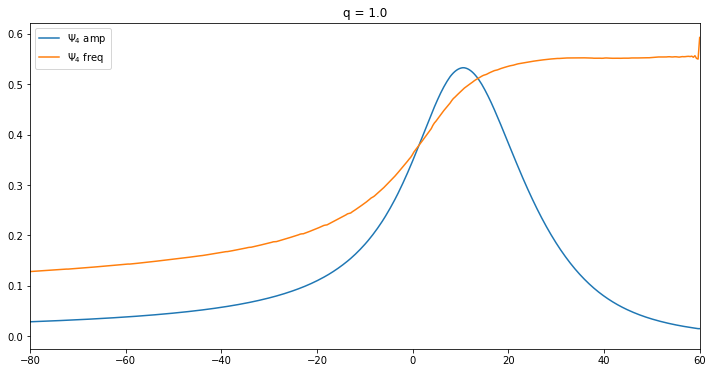

In [18]:
# compare psi4_amp and freq
k = 'q1'

plt.figure(figsize=(12, 6))
plt.plot(psi4s[k].nrdata.times, psi4s[k].psi4lm_amp / psi4s[k].eta * 1.8, label='$\Psi_4$ amp')
plt.plot(psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq, label='$\Psi_4$ freq')
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'q = {}'.format(psi4s[k].q))

# IRS ansatz

In [19]:
class Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2 + a2 / (t - tp)**3 + a3 / (t - tp)**4
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=20, min=-300, max=300)
        params.add('lor_amp', value=0., min=-2000, max=2000)
        params.add('a0', value=0., min=-200, max=2000, vary=True)
        params.add('a1', value=0., min=-400, max=400, vary=False)
        params.add('a2', value=0., min=-200, max=800, vary=False)
        params.add('a3', value=0., min=-200, max=800, vary=False)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [20]:
class Model2(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        
        t0 = params['t0']
        kappa = params['kappa']
        om_f = params['om_f']
        b = params['b']
        c = params['c']
        
        fhat = c / 2. * (1. + 1./kappa)**(1.+kappa) * (1. - (1.+1./kappa * np.exp(-2.*(t-t0)/b))**(-kappa))
        
        
        model = om_f * (1. - fhat)
            
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=5., min=-20, max=20)
        params.add('kappa', value=1, vary=True)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.2, min=1e-2, max=200)
        params.add('c', value=0., min=-2000, max=4000)

        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [21]:
class Model3(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']

        dt = t - t0
#         num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * (num/den)**kappa
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=5., min=-20, max=20)
        params.add('kappa', value=1, vary=True)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.2, min=1e-2, max=200)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [22]:
# psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq

In [23]:
# k = 'q1'
# k = 'q5'
k = 'q10'
# k = 'q18'

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 182
    # variables        = 4
    chi-square         = 2.0889e-04
    reduced chi-square = 1.1736e-06
    Akaike info crit   = -2481.33983
    Bayesian info crit = -2468.52380
##  Warning: uncertainties could not be estimated:
    offset:  at initial value
[[Variables]]
    t0:      2.69962262 (init = 5)
    kappa:   0.43905541 (init = 1)
    b:       11.27255 (fixed)
    om_f:    0.4158439 (fixed)
    offset:  0.20000000 (init = 0.2)
    c:       0.21033986 (init = 0)


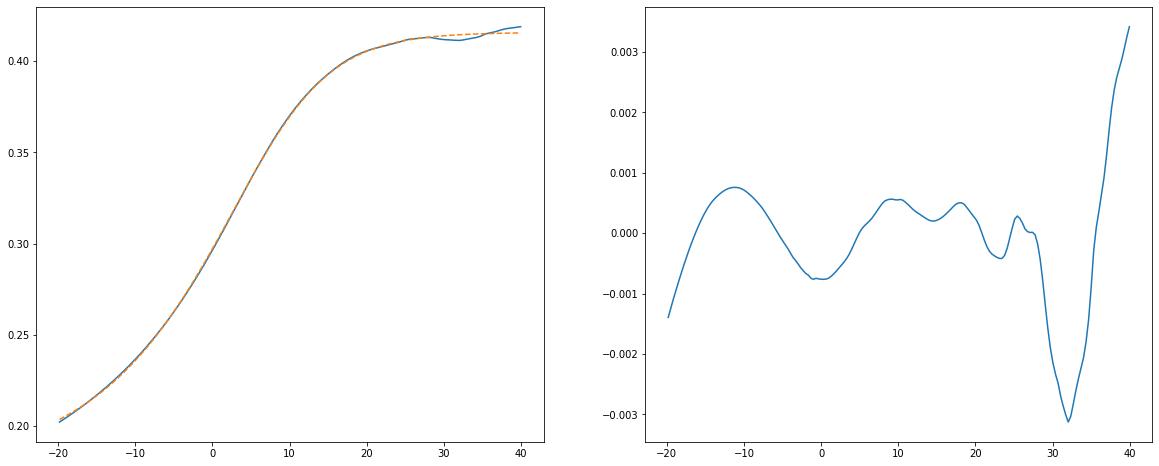

In [24]:
q1_fit_2 = Model2(psi4s[k])
q1_fit_2.fit_freq_mr(t1=-20, t2=40)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_2.fit_times, q1_fit_2.fit_data)
axes[0].plot(q1_fit_2.fit_times, q1_fit_2.freq_mr_final, ls='--')


axes[1].plot(q1_fit_2.fit_times, q1_fit_2.fit_data - q1_fit_2.freq_mr_final)

# new_times = np.linspace(-100, 30, 100)
# new_x = q1_fit_2.model_freq_mr_to_min(q1_fit_2.freq_mr_result.params, new_times, 0)

# plt.plot(new_times, new_x)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 152
    # variables        = 3
    chi-square         = 1.8109e-04
    reduced chi-square = 1.2154e-06
    Akaike info crit   = -2067.34162
    Bayesian info crit = -2058.26997
[[Variables]]
    t0:      6.67840179 +/- 0.20225939 (3.03%) (init = 5)
    kappa:   0.50905719 +/- 0.02187140 (4.30%) (init = 1)
    b:       11.27255 (fixed)
    om_f:    0.4158439 (fixed)
    offset:  0.18739813 +/- 0.00351914 (1.88%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, offset) =  0.988
    C(t0, kappa)     = -0.979
    C(t0, offset)    = -0.940


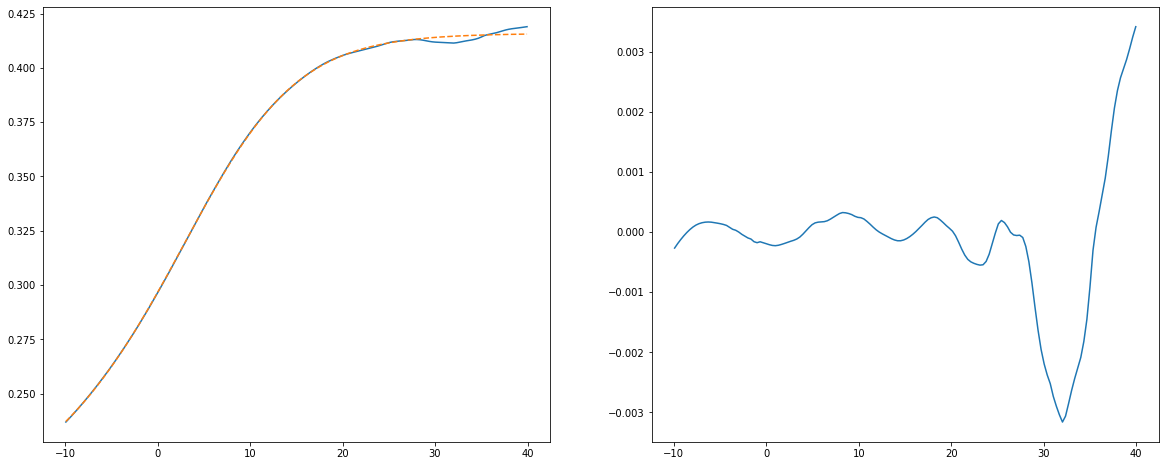

In [25]:
q1_fit_3 = Model3(psi4s[k])
# q1_fit_3.fit_freq_mr(t1=-30, t2=40)
q1_fit_3.fit_freq_mr(t1=-10, t2=40)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.fit_data)
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls='--')


axes[1].plot(q1_fit_3.fit_times, q1_fit_3.fit_data - q1_fit_3.freq_mr_final)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 318
    # variables        = 4
    chi-square         = 5.9004e-05
    reduced chi-square = 1.8791e-07
    Akaike info crit   = -4920.98770
    Bayesian info crit = -4905.93949
[[Variables]]
    tdamp:    74.6295390 +/- 0.35587660 (0.48%) (init = 20)
    tp:       54.3203646 +/- 0.18127308 (0.33%) (init = 20)
    lor_amp: -42.3841037 +/- 0.28247908 (0.67%) (init = 0)
    a0:      -36.1959057 +/- 0.17663261 (0.49%) (init = 0)
    a1:       0 (fixed)
    a2:       0 (fixed)
    a3:       0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a0)    =  0.996
    C(tdamp, tp)      =  0.996
    C(tdamp, a0)      = -0.973
    C(tp, a0)         = -0.964
    C(tdamp, lor_amp) = -0.951
    C(tp, lor_amp)    = -0.938


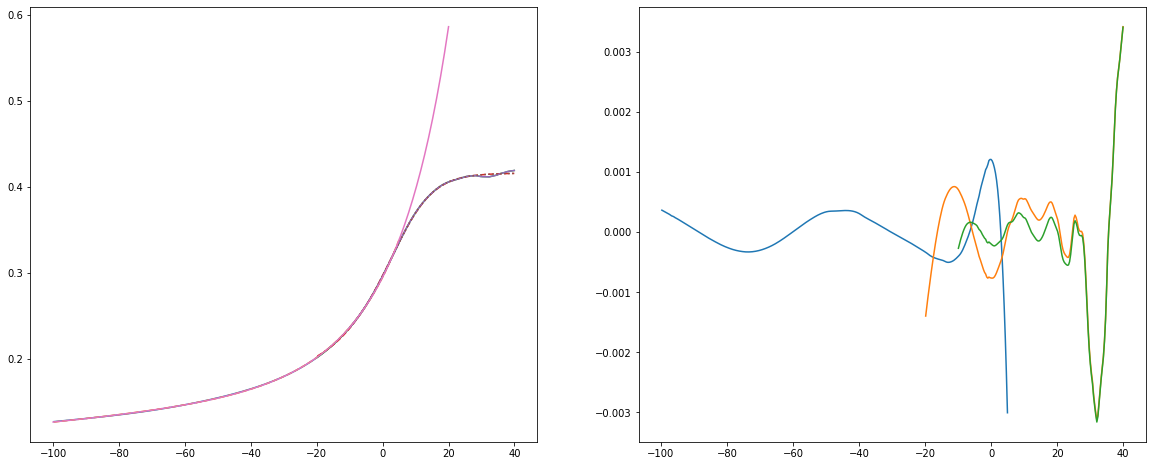

In [26]:
q1_fit = Model(psi4s[k])
# q1_fit.fit_freq_mr(t1=-100, t2=0)
# q1_fit.fit_freq_mr(t1=-100, t2=-5


# the current standard
q1_fit.fit_freq_mr(t1=-100, t2=5)

# q1_fit.fit_freq_mr(t1=-500, t2=5)

# q1_fit.fit_freq_mr(t1=-200, t2=-5)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit.fit_times, q1_fit.fit_data)
axes[0].plot(q1_fit.fit_times, q1_fit.freq_mr_final, ls='--')


axes[1].plot(q1_fit.fit_times, q1_fit.fit_data - q1_fit.freq_mr_final)



axes[0].plot(q1_fit_2.fit_times, q1_fit_2.fit_data)
axes[0].plot(q1_fit_2.fit_times, q1_fit_2.freq_mr_final, ls='--')

axes[0].plot(q1_fit_3.fit_times, q1_fit_3.fit_data)
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls=':')

axes[1].plot(q1_fit_2.fit_times, q1_fit_2.fit_data - q1_fit_2.freq_mr_final)

axes[1].plot(q1_fit_3.fit_times, q1_fit_3.fit_data - q1_fit_3.freq_mr_final)


# extrapolate
xs = np.linspace(-100,20,100)
ys = q1_fit.model_freq_mr(q1_fit.freq_mr_result.params, xs)
axes[0].plot(xs,ys)
# axes[0].set_yscale('log')



# amplitude modelling

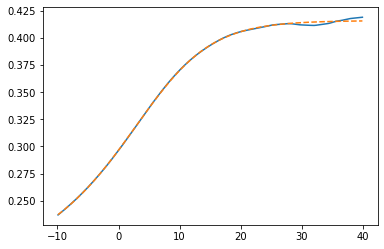

In [27]:
plt.figure()
plt.plot(q1_fit_3.fit_times, q1_fit_3.fit_data)
plt.plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls='--')

In [28]:
class Model_hlm_2(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
#         fhat = self.freq_data_y_new




        A0 = params['A0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        tp = params['tp']
        b = params['b']
        beta = params['beta']
        
        kappa = params['kappa']
        t0 = params['t0']

        fhat = ((1 + np.tanh( (t-t0)/b ))/2)**kappa
        
        den = 1. + (a1 * ( fhat**2 - fhat**4 ))
        den += a2 * (fhat**4 - fhat**6)
        den += a3 * (fhat**6 - fhat**8)
        
#         ifhat = IUS(t, fhat)
#         fhatdot = ifhat.derivative()(t)
        tanh_ab = np.tanh((t-t0)/b)
        tanh_ab_over_2_p_05 = tanh_ab/2 + 0.5

        fhatdot =  kappa*(1 - tanh_ab**2)*(tanh_ab_over_2_p_05)**kappa/(2*b*(tanh_ab_over_2_p_05))
        
#         den=1
        
#         sech = 1./np.cosh( (t-tp)/b )
#         fhatdot = sech
        
#         model = A0 * np.sqrt(np.abs(fhatdot) / den)
#         model = A0 * fhatdot / den
        model = A0 * fhatdot * den

    
        model = A0 * np.exp(-(t-tp)/b) * (1. - a1 * np.exp(-2*(t-tp)/b))
    
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, freq_data_x, freq_data_y, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_freq_mr_mask = (self.Psi4.times_news > t1) & (self.Psi4.times_news < t2)
        self.fit_times = self.Psi4.times_news[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.newslm_amp[self.model_freq_mr_mask]

#         self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
#         self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.hlm_amp[self.model_freq_mr_mask]
        
        # resample freq data onto common time grid
        ifreq = IUS(freq_data_x, freq_data_y)
        self.freq_data_y_new = ifreq(self.fit_times)
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('A0', value=1., min=-20, max=20)
        params.add('a1', value=0., min=-200, max=5000, vary=True)
        params.add('a2', value=0., min=-200, max=5000, vary=True)
        params.add('a3', value=0., min=-200, max=5000, vary=True)
        params.add('beta', value=1., min=-2000, max=2000)
        params.add('tp', value=1., min=-200, max=200)
#         params.add('b', value=2., min=1, max=200)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        
        params.add('t0', value=1., min=-200, max=200)
        params.add('kappa', value=1., min=1e-8, max=2000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [29]:
class Model_hlm(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
#         fhat = self.freq_data_y_new




        A0 = params['A0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        tp = params['tp']
        b = params['b']
        beta = params['beta']
        
        kappa = params['kappa']
        t0 = params['t0']

        fhat = ((1 + np.tanh( (t-t0)/b ))/2)**kappa
        
        den = 1. + (a1 * ( fhat**2 - fhat**4 ))
        den += a2 * (fhat**4 - fhat**6)
        den += a3 * (fhat**6 - fhat**8)
        
#         ifhat = IUS(t, fhat)
#         fhatdot = ifhat.derivative()(t)
        tanh_ab = np.tanh((t-t0)/b)
        tanh_ab_over_2_p_05 = tanh_ab/2 + 0.5

        fhatdot =  kappa*(1 - tanh_ab**2)*(tanh_ab_over_2_p_05)**kappa/(2*b*(tanh_ab_over_2_p_05))
        
#         den=1
        
#         sech = 1./np.cosh( (t-tp)/b )
#         fhatdot = sech
        
#         model = A0 * np.sqrt(np.abs(fhatdot) / den)
#         model = A0 * fhatdot / den
        model = A0 * fhatdot * den

        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, freq_data_x, freq_data_y, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times_news > t1) & (self.Psi4.times_news < t2)
#         self.fit_times = self.Psi4.times_news[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.newslm_amp[self.model_freq_mr_mask]**2

        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_amp[self.model_freq_mr_mask]**2
        
        # resample freq data onto common time grid
        ifreq = IUS(freq_data_x, freq_data_y)
        self.freq_data_y_new = ifreq(self.fit_times)
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('A0', value=1., min=-20, max=20)
        params.add('a1', value=0., min=-200, max=5000, vary=True)
        params.add('a2', value=0., min=-200, max=5000, vary=True)
        params.add('a3', value=0., min=-200, max=5000, vary=True)
        params.add('beta', value=1., min=-2000, max=2000)
        params.add('tp', value=1., min=-200, max=200)
#         params.add('b', value=2., min=1, max=200)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        
        params.add('t0', value=1., min=-200, max=200)
        params.add('kappa', value=1., min=1e-8, max=2000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data points      = 135
    # variables        = 8
    chi-square         = 4.1088e-08
    reduced chi-square = 3.2352e-10
    Akaike info crit   = -2942.23247
    Bayesian info crit = -2918.99027
##  Warning: uncertainties could not be estimated:
    beta:   at initial value
    t0:     at initial value
    kappa:  at initial value
[[Variables]]
    A0:     0.32475244 (init = 1)
    a1:     13.0213520 (init = 0)
    a2:    -1.4211e-13 (init = 0)
    a3:    -1.4211e-13 (init = 0)
    beta:   1.00000000 (init = 1)
    tp:    -15.8434864 (init = 1)
    b:      11.27255 (fixed)
    t0:     1.00000000 (init = 1)
    kappa:  1.00000000 (init = 1)


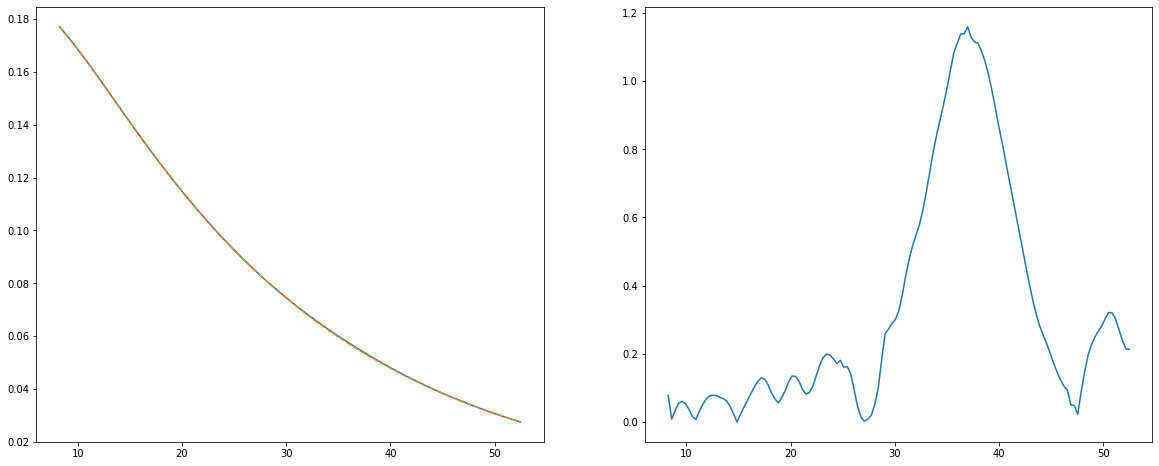

In [30]:
q1_fit_news_2 = Model_hlm_2(psi4s[k])
q1_fit_news_2.fit_freq_mr(q1_fit_3.fit_times, q1_fit_3.fit_data, t1=8, t2=60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(q1_fit_news_2.fit_times, np.sqrt(q1_fit_news_2.fit_data))
axes[0].plot(q1_fit_news_2.fit_times, np.sqrt(q1_fit_news_2.freq_mr_final), ls='--')
# axes[0].set_xlim(-30,30)
# axes[0].set_yscale('log')

dnr=q1_fit_news_2.fit_data
dfit=q1_fit_news_2.freq_mr_final

axes[1].plot(q1_fit_news_2.fit_times, np.abs((dnr-dfit)/dnr) * 100)
# axes[1].set_yscale('log')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 159
    # data points      = 302
    # variables        = 8
    chi-square         = 4.2272e-08
    reduced chi-square = 1.4378e-10
    Akaike info crit   = -6836.25157
    Bayesian info crit = -6806.56815
##  Warning: uncertainties could not be estimated:
    beta:   at initial value
    tp:     at initial value
[[Variables]]
    A0:     0.98235226 (init = 1)
    a1:     4.14455049 (init = 0)
    a2:    -12.8386013 (init = 0)
    a3:     15.1197365 (init = 0)
    beta:   1.00000000 (init = 1)
    tp:     1.00000000 (init = 1)
    b:      11.27255 (fixed)
    t0:     12.2826852 (init = 1)
    kappa:  0.06983982 (init = 1)


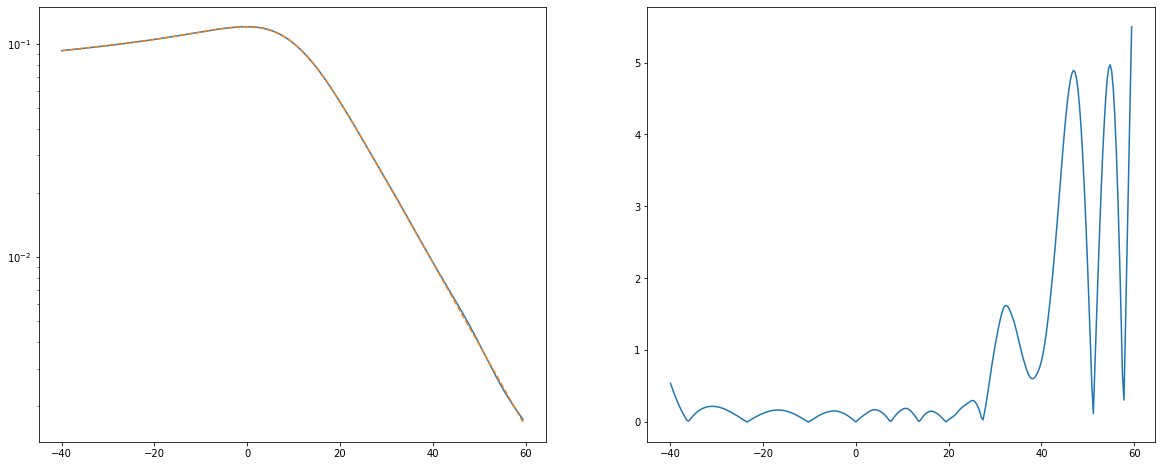

In [31]:
q1_fit_news = Model_hlm(psi4s[k])
q1_fit_news.fit_freq_mr(q1_fit_3.fit_times, q1_fit_3.fit_data, t1=-40, t2=60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(q1_fit_news.fit_times, np.sqrt(q1_fit_news.fit_data))
axes[0].plot(q1_fit_news.fit_times, np.sqrt(q1_fit_news.freq_mr_final), ls='--')
# axes[0].set_xlim(-30,30)
axes[0].set_yscale('log')

dnr=q1_fit_news.fit_data
dfit=q1_fit_news.freq_mr_final

axes[1].plot(q1_fit_news.fit_times, np.abs((dnr-dfit)/dnr) * 100)
# axes[1].set_yscale('log')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 174
    # data points      = 181
    # variables        = 8
    chi-square         = 1.0216e-08
    reduced chi-square = 5.9051e-11
    Akaike info crit   = -4255.20528
    Bayesian info crit = -4229.61730
##  Warning: uncertainties could not be estimated:
    beta:   at initial value
    tp:     at initial value
[[Variables]]
    A0:     0.97424264 (init = 1)
    a1:     3.45840398 (init = 0)
    a2:    -10.6363762 (init = 0)
    a3:     12.6310409 (init = 0)
    beta:   1.00000000 (init = 1)
    tp:     1.00000000 (init = 1)
    b:      11.27255 (fixed)
    t0:     11.9225103 (init = 1)
    kappa:  0.07571683 (init = 1)


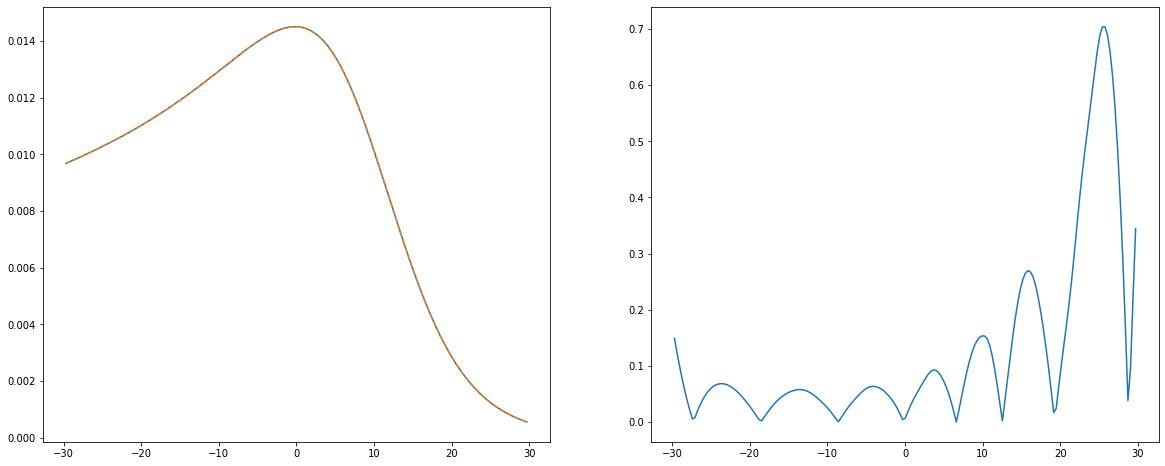

In [32]:
q1_fit_news = Model_hlm(psi4s[k])
q1_fit_news.fit_freq_mr(q1_fit_3.fit_times, q1_fit_3.fit_data, t1=-30, t2=30)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_news.fit_times, q1_fit_news.fit_data)
axes[0].plot(q1_fit_news.fit_times, q1_fit_news.freq_mr_final, ls='--')
# axes[0].set_yscale('log')

dnr=q1_fit_news.fit_data
dfit=q1_fit_news.freq_mr_final

axes[1].plot(q1_fit_news.fit_times, np.abs((dnr-dfit)/dnr) * 100)
# axes[1].set_yscale('log')

In [33]:
q1_fit_news.fit_freq_mr

<bound method Model_hlm.fit_freq_mr of <__main__.Model_hlm object at 0x1a1f3d11d0>>

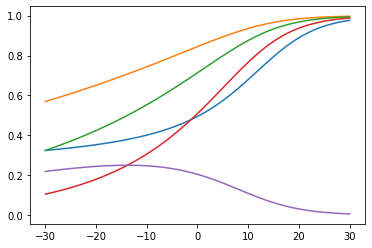

In [34]:
plt.figure()

xs = np.linspace(-30, 30 ,100)

a1 = q1_fit_news.freq_mr_result.params['a1']
t0 = q1_fit_news.freq_mr_result.params['t0']
b = q1_fit_news.freq_mr_result.params['b']
kappa = q1_fit_news.freq_mr_result.params['kappa']

fhat = ((1 + np.tanh( (xs-t0)/b ))/2)**kappa
ys = 1. + (a1 * ( fhat**2 - fhat**4 ))

plt.plot(xs, fhat/ys)
plt.plot(xs, fhat)
plt.plot(xs, fhat**2)
plt.plot(xs, fhat**4)
plt.plot(xs, fhat**2 - fhat**4)

## freq derivative - 1st try

In [35]:
def freq(a,b,y):    
    return ((1. + np.tanh(a/b))/2.)**y

In [36]:
# These commands were executed:
# >>> from __future__ import division
# >>> from sympy import *
# >>> x, y, z, t = symbols('x y z t')
# >>> diff(((1 + tanh(x/z))/2)**y, x)


In [37]:


def freq_deriv(a,b,y):
    
    tanh_ab = np.tanh(a/b)
    tanh_ab_over_2_p_05 = tanh_ab/2 + 0.5
    
#     return y*(1 - np.tanh(a/b)**2)*(np.tanh(a/b)/2 + 0.5)**y/(2*b*(np.tanh(a/b)/2 + 0.5))

    return y*(1 - tanh_ab**2)*(tanh_ab_over_2_p_05)**y/(2*b*(tanh_ab_over_2_p_05))

#     return 2**(-y) * (np.tanh(a/b)+1)**y * np.log(0.5*(np.tanh(a/b)+1))

In [38]:
freq(1, 10, 1)

0.549833997312478

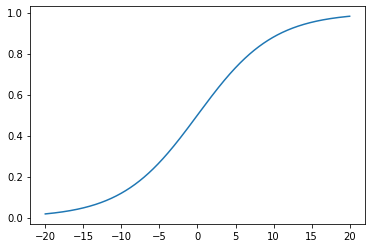

In [39]:
plt.figure()
xs = np.linspace(-20,20,1000)
ys = freq(xs, 10, 1)
plt.plot(xs, ys)

In [40]:
iys = IUS(xs, ys)

In [41]:
ys_diff = iys.derivative()(xs)

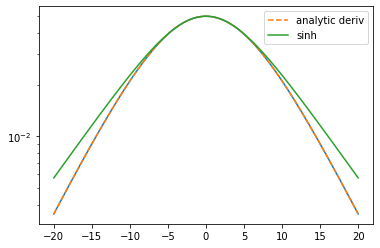

In [42]:
plt.figure()
plt.plot(xs, ys_diff)
plt.plot(xs, freq_deriv(xs, 10, 1), ls='--', label='analytic deriv')
plt.plot(xs, 1./np.cosh(xs/7)/20, label='sinh')
plt.yscale('log')
plt.legend()

## freq derivative - 2nd try

In [43]:
def freq(t, t0, a1, af, b, kappa):

    dt = t - t0
    num = 1. + np.tanh((dt/b))
    den = 2.

    return a1 + (af - a1) * (num/den)**kappa

In [44]:
# These commands were executed:
# >>> from __future__ import division
# >>> from sympy import *
# >>> x, y, z, t = symbols('x y z t')
# t, t0, a1, af, b, kappa = symbols('t, t0, a1, af, b, kappa')
# diff( a1 + (af-a1) * ( ( 1 + tanh((t-t0)/b) )/2  )**kappa, t  )

In [45]:
def freq_deriv(t, t0, a1, af, b, kappa):
    
    return kappa*(1 - np.tanh((t - t0)/b)**2)*(-a1 + af)*(np.tanh((t - t0)/b)/2 + 0.5)**kappa/(2*b*(np.tanh((t - t0)/b)/2 + 0.5))

In [46]:
freq(1, 0, 0, 2, 10, 1)

1.099667994624956

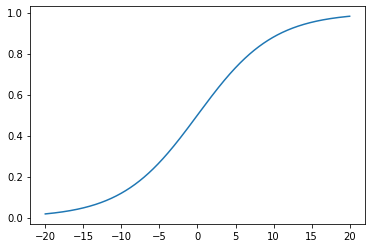

In [47]:
plt.figure()
xs = np.linspace(-20,20,1000)
ys = freq(xs, 0, 0, 1, 10, 1)
plt.plot(xs, ys)

In [48]:
iys = IUS(xs, ys)

In [49]:
ys_diff = iys.derivative()(xs)

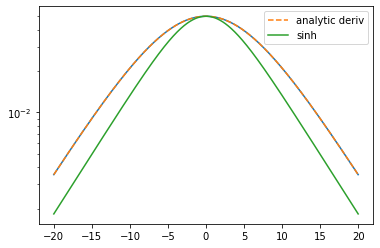

In [50]:
plt.figure()
plt.plot(xs, ys_diff)
plt.plot(xs, freq_deriv(xs, 0, 0, 1, 10, 1), ls='--', label='analytic deriv')
plt.plot(xs, 1./np.cosh(2*xs/10)/20, label='sinh')
plt.yscale('log')
plt.legend()

# compare fhat

In [51]:
def fhat(t, t0, b, kappa, c, d=1):
    fhat = c / 2. * (1. + 1./kappa)**(1.+kappa) * (d*1. - (1.+1./kappa * np.exp(-2.*(t-t0)/b))**(-kappa))

#     model = om_f * (1. - fhat)
    model = fhat
    
    return model

In [52]:
# def my_freq(t, t0, a1, af, b, kappa):

#     dt = t - t0
#     num = 1. + np.tanh((dt/b))
#     den = 2.

# #     return a1 + (af - a1) * (num/den)**kappa
#     return (num/den)**kappa

In [53]:
def my_fhat(t, t0, b, kappa, c, d=1):

    dt = t - t0
    num = 1. + np.tanh((dt/b))
    den = 2.

    
    return c/2 * (1 + 1/kappa)**(1+kappa) * (d*1 + (num/den)**kappa)

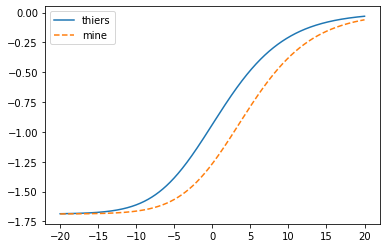

In [54]:
plt.figure()
xs = np.linspace(-20,20,1000)
# ys = (fhat(xs, 0, 1, 1, 1, 1) + 2)/2
ys = fhat(xs, 0, 10, 2, 1, d=1)
# ys_m = my_freq(xs, 0, 0, 1, 1, 1)
ys_m_2 = my_fhat(xs, 0, 10, 2, 1, d=-1)
plt.plot(xs, -ys, label='thiers')
# plt.plot(xs, ys_m, label='mine', ls='--')
plt.plot(xs, ys_m_2, label='mine', ls='--')
plt.legend()

# compare fhat again

In [55]:
def baker(t, t0=0, c=1, k=1, b=1):

    T = (1 + np.exp(-2 * (t-t0)/b)/k )**(-k)
#     K = (1+1/k)**(1+k)
#     return c/2 * K * (1 - T)
    return (1 - T)

In [56]:
def khan(t, t0=0, c=1, k=1, b=1):
    T = ((1 + np.tanh(np.log(np.sqrt(k)) + (t-t0)/b))/2)**k
#     K = (1+1/k)**(1+k)
#     return c/2 * K * (1 - T)
    return (1 - T)

In [57]:
def khan2(t, t0=0, Ap=1, b=1):
    T = (np.pi/2 + 2 * Ap * b * np.arctan(np.tanh( (t-t0)/(2*b))) ) / np.pi
#     T = (1 + 1./np.pi * 4 * Ap * b * np.arctan(np.tanh((t-t0)/(2*b))) ) / 2
    return (1 - T)

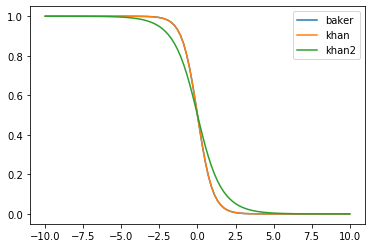

In [58]:
ts = np.linspace(-10, 10, 100)
plt.figure()

ys = baker(ts, k=1)
ys2 = khan(ts, k=1)
ys3 = khan2(ts)

plt.plot(ts, ys, label='baker')
plt.plot(ts, ys2, label='khan')
plt.plot(ts, ys3, label='khan2')
plt.legend()

# try fitting my 'BOB' derived IRS type model - frequency

In [59]:
class Model_m1(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']

        dt = t - t0
        num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
#         num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * (num/den)**kappa
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]
        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.newslm_ang_freq[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=0, min=-20, max=20, vary=True)
        params.add('kappa', value=1, min=1e-3, max=200, vary=True)
        params.add('gamma', value=1, min=1e-3, max=200, vary=True)
        params.add('b', value=-1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.2, min=1e-3, max=200, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [60]:
# k = 'q1'
k = 'q5'
# k = 'q10'
# k = 'q18'

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 152
    # variables        = 4
    chi-square         = 9.1835e-05
    reduced chi-square = 6.2051e-07
    Akaike info crit   = -2168.54859
    Bayesian info crit = -2156.45307
##  Warning: uncertainties could not be estimated:
    gamma:   at initial value
[[Variables]]
    t0:      2.96492993 (init = 0)
    kappa:   0.50491623 (init = 1)
    gamma:   1.00000000 (init = 1)
    b:      -11.32931 (fixed)
    om_f:    0.4515199 (fixed)
    offset:  0.18851538 (init = 0.2)


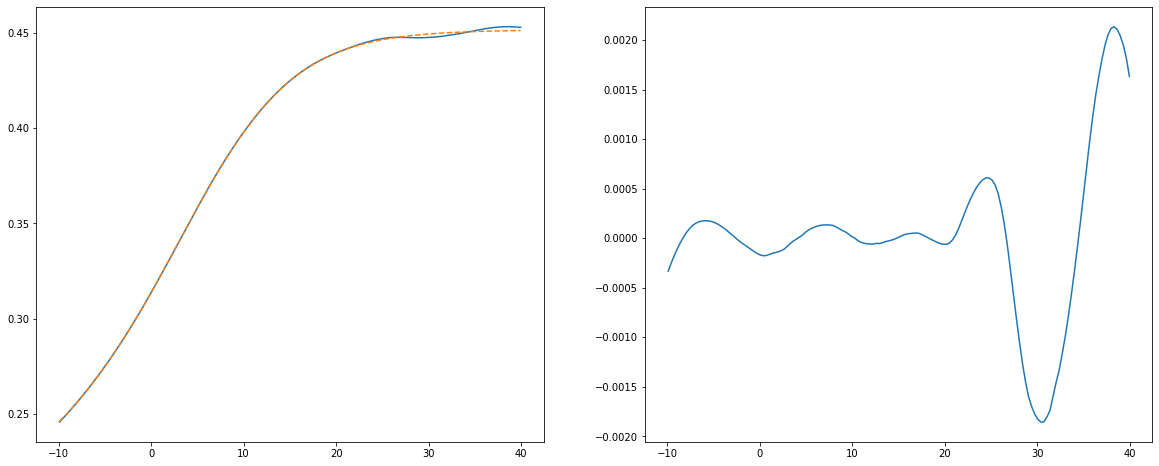

In [61]:
q1_fit_m1 = Model_m1(psi4s[k])
q1_fit_m1.fit_freq_mr(t1=-10, t2=40)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_m1.fit_times, q1_fit_m1.fit_data)
axes[0].plot(q1_fit_m1.fit_times, q1_fit_m1.freq_mr_final, ls='--')


axes[1].plot(q1_fit_m1.fit_times, q1_fit_m1.fit_data - q1_fit_m1.freq_mr_final)

# try fitting my 'BOB' derived IRS type model - amplitude

In [62]:
class Model_m2(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        tp = params['tp']
        Ap = params['Ap']
        b = params['tdamp']
        
        fhat = 2 * Ap * b * np.arctan( np.tanh( (t-tp) / (2*b) ) )

        alpha = params['alpha']
        A0 = params['A0']
        
        Ap2 = params['Ap2']
        
        
        den = 1. + (alpha * ( fhat**2 - fhat**4 ))
        
        fhatdot = Ap2 * 1./np.cosh( (t-tp)/b )
        
#         model = np.sqrt(  A0 * np.abs(fhatdot) / np.abs(den)  )
#         model = A0 * fhatdot / den  
#         model = fhatdot / den  
        
        model = fhatdot

        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]

#         self.model_freq_mr_mask = (self.Psi4.nrdata.times > t1) & (self.Psi4.nrdata.times < t2)
#         self.fit_times = self.Psi4.nrdata.times[self.model_freq_mr_mask]

        self.model_freq_mr_mask = (self.Psi4.times_news > t1) & (self.Psi4.times_news < t2)
        self.fit_times = self.Psi4.times_news[self.model_freq_mr_mask]

#         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.newslm_ang_freq[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.hlm_amp[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.newslm_amp[self.model_freq_mr_mask]

        
        # create a set of Parameters
        params = Parameters()
        
#         params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=1, min=-20, max=20)
        params.add('Ap', value=1., min=-200, max=200)
#         params.add('ai', value=1., min=-200, max=200, vary=True)
#         params.add('af', value=0., min=-2000, max=2000, vary=True)
        
        params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=True)
        
#         params.add('af', value=self.Psi4.fring*2*np.pi, vary=True)
        
        params.add('A0', value=1., min=-20, max=20)
        params.add('alpha', value=1., min=-20, max=20)
        params.add('Ap2', value=1., min=-20, max=20)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [63]:
k = 'q1'
# k = 'q5'
# k = 'q10'
# k = 'q18'

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 61
    # variables        = 6
    chi-square         = 7.1085e-05
    reduced chi-square = 1.2924e-06
    Akaike info crit   = -821.413382
    Bayesian info crit = -808.748139
##  Warning: uncertainties could not be estimated:
    Ap:     at initial value
    A0:     at initial value
    alpha:  at initial value
[[Variables]]
    tp:    -0.67279832 (init = 1)
    Ap:     1.00000000 (init = 1)
    tdamp:  12.5743728 (init = 11.70642)
    A0:     1.00000000 (init = 1)
    alpha:  1.00000000 (init = 1)
    Ap2:    0.15909480 (init = 1)


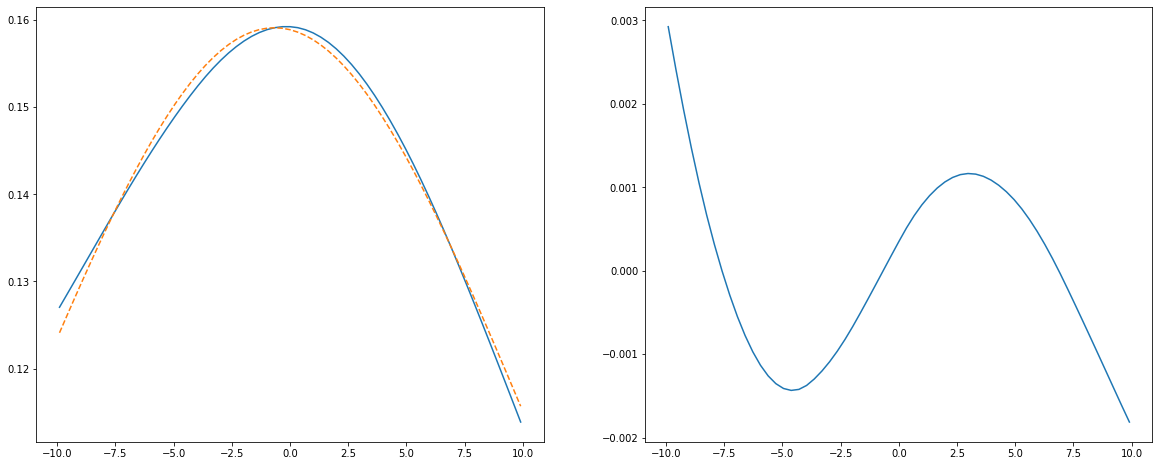

In [64]:
q1_fit_m2 = Model_m2(psi4s[k])
q1_fit_m2.fit_freq_mr(t1=-10, t2=10)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_m2.fit_times, q1_fit_m2.fit_data)
axes[0].plot(q1_fit_m2.fit_times, q1_fit_m2.freq_mr_final, ls='--')


axes[1].plot(q1_fit_m2.fit_times, q1_fit_m2.fit_data - q1_fit_m2.freq_mr_final)

# PN amplitude

To construct the PN amplitude we need v(t) / x(t) / Omega(t)

We can use TaylorT3 for this

In [65]:
# https://arxiv.org/pdf/0710.0158.pdf
#https://arxiv.org/pdf/gr-qc/9602024.pdf

# 0907.0700 BIPOS paper


def T3theta(t, t0, eta, M):
    """
    0907.0700: page 7 above eq. 3.10a
    """
    tau = eta * (t0 - t) / (5 * M)
#     tau = np.sqrt(tau**2 + 1) # eq.9 in 0901.2437
    return tau**(-1./8)

def T3phi(t, t0, eta, M, phi0=0):
    """
    0907.0700: eq. 3.10a
    returns the Orbital phase
    """
    
    theta = T3theta(t, t0, eta, M)
    
    theta5 = theta**5
    
    gamma = 0.577216
    
    pre = 1./(eta * theta5)
    
    t1 = 1.
    t2 = 3715/8064. + 55*eta / 96.
    t3 = 3.*np.pi/4
    t4 = 9275495./14450688 + 284875*eta/258048 + 1855*eta/2048
    # others terms not coded yet

    
    return phi0 - pre * (t1 + t2*theta**2 - t3*theta**3 + t4*theta**4)

def T3OrbAngFreq(t, t0, eta, M):
    """
    0907.0700: eq. 3.10b
    returns the Orbital angular frequency
    which is 3.10b / 2 * 2 * pi
    """
    
    theta = T3theta(t, t0, eta, M)
    
    theta3 = theta**3
    
    gamma = 0.577216
    
    pre = theta3 / (8.*np.pi*M)
    pre_to_orb_ang_freq = 2.*np.pi/2
    
    t1 = 1.
    t2 = 743/2688. + 11.*eta/32
    t3 = 3.*np.pi/10
    t4 = 1855099./14450688 + 56975.*eta/258048 + 371*eta**2/2048
    t5 = 7729/21504. - 13*eta/256
    
    t6 = 720817631400877./288412611379200 + 53*np.pi**2/200 + 170*gamma/280 \
        + (25302017977./4161798144 - 451*np.pi**2/2048)*eta \
        - 30913.*eta**2/1835008 + 235925.*eta**3/1769472
    t6log = 107. * np.log(2*theta)/280
    
    t7 = -188516689./433520640 - 97765*eta/258048 + 141769*eta**2/1290240
    
    # others terms not coded yet

    
    return pre_to_orb_ang_freq * pre * (t1 + t2*theta**2 - t3*theta**3 + t4*theta**4  - t5*theta**5 + (t6+t6log)*theta**6 + t7*np.pi*theta**7)

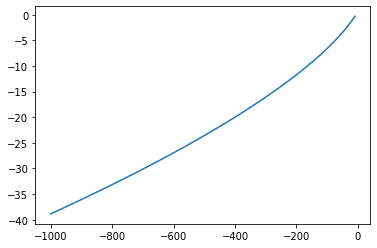

In [66]:
plt.figure()
xs = np.linspace(-1000, -10, 100)
ys = T3phi(xs, -5, 0.25, 1, 0)
plt.plot(xs, ys)

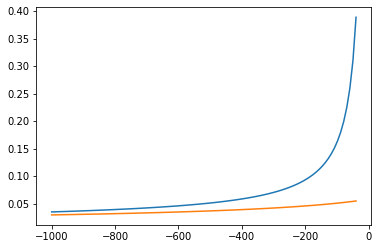

In [67]:
plt.figure()
xs = np.linspace(-1000, -40, 100)
ys = T3OrbAngFreq(xs, -5, 0.25, 1)
ys_2 = T3OrbAngFreq(xs, 400, 0.25, 1)
plt.plot(xs, ys)
plt.plot(xs, ys_2)

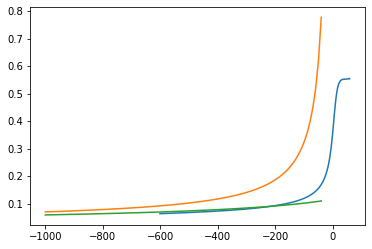

In [68]:
k='q1'
plt.figure()
plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_ang_freq)
plt.plot(xs, ys*2)
plt.plot(xs, ys_2*2)

In [69]:
# https://arxiv.org/pdf/0802.1249.pdf
def Hhat22(t, t0, eta, M):


    OrgAngFreq = T3OrbAngFreq(t, t0, eta, M)
    
    x = (M*OrgAngFreq)**(2./3)
    
    
    xarr = np.zeros(6, dtype=np.complex128)
#     xarr = np.zeros(6)
    
    C = 0.577216 # is the Euler constant

    xarr[0] = 1.
    xarr[1] = -107./42 + 55*eta/42
    xarr[2] = 2.*np.pi
    xarr[3] = -2173./1512 - 1069*eta/216 + 2047*eta**2/1512
    xarr[4] = (-107*np.pi/21 - 24*1.j*eta + 34*np.pi*eta/21) # there is an i... not sure what to do...
    
    x5a = 27027409/646800 - 856*C/105 + 428*1.j*np.pi/105 + 2*np.pi**2/3
    x5b = (-278185/33264 + 41*np.pi**2/96)*eta - 20261*eta**2/2772 + 114635*eta**3/99792
    
    x5log =  - 428*np.log(16*x)/105
    
    xarr[5] = (x5a) + x5b # there is an i...  not sure what to do...
    
    pre = np.sqrt(16*np.pi/5)
    
    pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3] + x**(5/2.)*xarr[4] + x**3*(xarr[5] + x5log)
#     pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3]
    
    return pre * pn

In [70]:
xs = np.linspace(-1000,-200,100)
# pn_h22 = Hhat22(xs, -5, 0.25, 1)
pn_h22 = Hhat22(xs, -5, psi4s['q1'].eta, 1)
pn_h22_2 = Hhat22(xs, -90, psi4s['q1'].eta, 1)

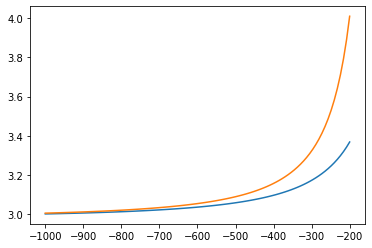

In [71]:
plt.figure()
plt.plot(xs, np.abs(pn_h22))
plt.plot(xs, np.abs(pn_h22_2))

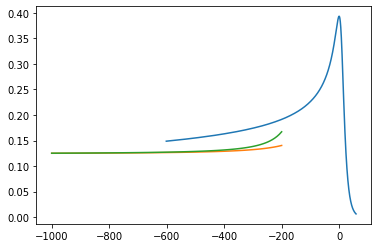

In [72]:
k='q1'
plt.figure()
plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp)
# plt.plot(psi4s[k].hlm_ang_freq, psi4s[k].hlm_amp)
plt.plot(xs, np.abs(pn_h22)/10/2/1.2)
plt.plot(xs, np.abs(pn_h22_2)/10/2/1.2)
# plt.yscale('log')
# plt.xlim(-1000,-200)
# plt.ylim(0,0.4)

In [73]:
from pycbc import waveform

In [74]:
t3hp, t3hc = waveform.get_td_waveform(approximant='TaylorT3', mass1=50, mass2=50, f_lower=15, delta_t=1./1024/2)

In [75]:
t3amp = waveform.amplitude_from_polarizations(t3hp, t3hc)
t3freq = waveform.frequency_from_polarizations(t3hp, t3hc)

In [76]:
mtot = 50+50
times_M = phenom.StoM(t3hp.sample_times, mtot)
times_M_freq = phenom.StoM(t3freq.sample_times, mtot)

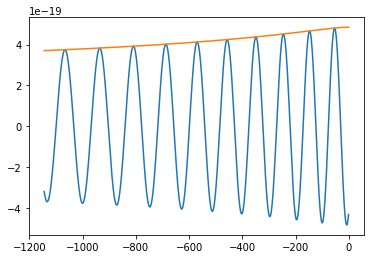

In [77]:
plt.figure()
plt.plot(times_M, t3hp)
plt.plot(times_M, t3amp)

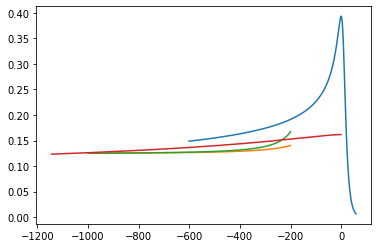

In [78]:
k='q1'
plt.figure()
plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp)
# plt.plot(psi4s[k].hlm_ang_freq, psi4s[k].hlm_amp)
plt.plot(xs, np.abs(pn_h22)/10/2/1.2)
plt.plot(xs, np.abs(pn_h22_2)/10/2/1.2)
plt.plot(times_M, t3amp*1e19/30)
# plt.yscale('log')
# plt.xlim(-1000,-200)
# plt.ylim(0,0.4)

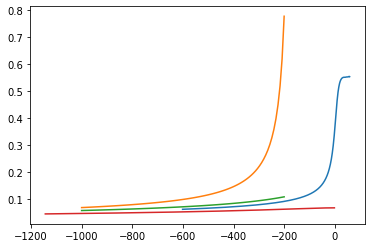

In [79]:
k='q1'
plt.figure()
plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_ang_freq)
plt.plot(xs, ys*2)
plt.plot(xs, ys_2*2)
plt.plot(times_M_freq, phenom.HztoMf(t3freq,mtot) * 2*np.pi)